# Reservoir Computing and Mackey-Glass prediction

This notebook is an example of Mackey-Glass prediction using Reservoir Computing, towards an optical implementation.

## Initialization

In [21]:
import numpy as np
import time

from reservoir import Reservoir
import data1D

%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data generation

In [303]:
input_data = data.mackey_glass(sequence_length=2000)
horizon = 2  # up to how many timesteps in the future we want to predict
output_data = np.zeros(input_data.shape[0:-1] + (horizon,))
for i_step in range(horizon):
    temp = np.roll(input_data, -(i_step+1), axis=1)
    output_data[:, :, i_step] = np.squeeze(np.roll(input_data, -(i_step+1), axis=1))

## Reservoir initialization

In [304]:
b = Reservoir(n_res=1000, input_scale=2, train_method='ridge', train_param=1e2,
              weights_type='complex gaussian', random_projection='simulation',
              activation_fun='binary', activation_param=1, encoding_method='naive_binary',
              input_dim=100, forget=100)

## Reservoir Training

In [305]:
y = output_data
b.fit(input_data, y);

Start of training...
Initialization finished. Elapsed time:
0.07437944412231445
100%|██████████| 2000/2000 [00:01<00:00, 1191.78it/s]
Iterations finished. Elapsed time:
1.754845142364502
Training finished. Elapsed time:
1.8852083683013916
Training score:
0.982214879603867


## Reservoir Validation

In [306]:
input_data = data1D.mackey_glass(sequence_length=2000)
output_data = np.zeros(input_data.shape[0:-1] + (horizon,))
for i_step in range(horizon):
    temp = np.roll(input_data, -(i_step+1), axis=1)
    output_data[:, :, i_step] = np.squeeze(np.roll(input_data, -(i_step+1), axis=1))

In [307]:
y = output_data
pred_output, valid_score = b.score(input_data, y);

Start of testing...
Initialization finished. Elapsed time:
0.0008304119110107422
100%|██████████| 2000/2000 [00:01<00:00, 1235.71it/s]
Iterations finished. Elapsed time:
1.62312650680542
Testing finished. Elapsed time:
1.6258511543273926
Testing finished. Elapsed time:
1.8852083683013916
Testing score:
0.968064614684969


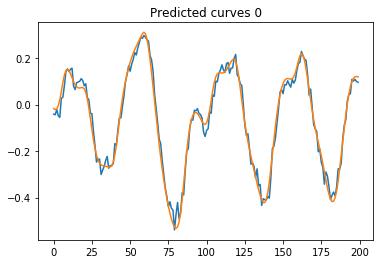

In [308]:
plot_length = 200
for i_fig in range(1):
    plt.figure(i_fig)
    plt.plot(pred_output[:plot_length, i_fig])
    plt.plot(y[0, b.forget:b.forget+plot_length, i_fig])
    plt.title('Predicted curves ' + str(i_fig))
    plt.show()